# Reward-Only Temporal Discounting Baseline (Collapsed Bins)

This notebook implements a minimal baseline model for temporal discounting using memo.

**Model:**
- For each participant p and task j, discrete distribution over lateness l ∈ {0,1,2,3,4,5}
- Early/on-time completions are collapsed into a single bin (l = 0)
- Utility: U_pj(l) = beta_p * reward_points_j * (gamma ** l) where gamma = 0.9
- Convert utilities to probabilities with softmax
- Weak prior on beta_p: Normal(0,5) passed through softplus
- MAP inference for each beta_p using memo


In [20]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from enum import IntEnum
from typing import no_type_check
import jax
import jax.numpy as jnp
from memo import memo

# Set random seed for reproducibility
np.random.seed(42)
jax.config.update("jax_enable_x64", True)

# Set up paths
# Try to find project root by looking for data/ directory
current_dir = Path.cwd()
if (current_dir / 'data').exists():
    PROJECT_ROOT = current_dir
elif (current_dir.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent
elif (current_dir.parent.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent.parent
else:
    PROJECT_ROOT = current_dir  # Fallback to current directory

# Create plots directory
PLOTS_DIR = PROJECT_ROOT / 'plots'
PLOTS_DIR.mkdir(exist_ok=True)
print(f"Project root: {PROJECT_ROOT}")
print(f"Plots will be saved to: {PLOTS_DIR}")


Project root: /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project
Plots will be saved to: /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots


In [21]:
# Data loading and minimal preprocessing
df = pd.read_csv(PROJECT_ROOT / 'data' / 'aggregated_data.csv')

# Filter for completed tasks only (where days_late is not NaN)
df_completed = df[df['completed'] == True].copy()
df_completed = df_completed[df_completed['days_late'].notna()].copy()

# Collapse early/on-time into single bin: lateness = max(0, days_late)
# Clip to [-5, 5] range first, then map negative values to 0
df_completed['days_late_clipped'] = df_completed['days_late'].clip(-5, 5).astype(int)
df_completed['lateness_bin'] = df_completed['days_late_clipped'].apply(lambda x: max(0, x))

print(f"Total completed tasks: {len(df_completed)}")
print(f"Unique participants: {df_completed['participant_id'].nunique()}")
print(f"Unique tasks: {df_completed['task'].nunique()}")
print(f"\nOriginal days late distribution:")
print(df_completed['days_late_clipped'].value_counts().sort_index())
print(f"\nCollapsed lateness bin distribution:")
print(df_completed['lateness_bin'].value_counts().sort_index())


Total completed tasks: 16
Unique participants: 5
Unique tasks: 6

Original days late distribution:
days_late_clipped
-5    2
-3    3
-1    2
 0    5
 1    2
 2    1
 4    1
Name: count, dtype: int64

Collapsed lateness bin distribution:
lateness_bin
0    12
1     2
2     1
4     1
Name: count, dtype: int64


In [22]:
# Define lateness bins: {0, 1, 2, 3, 4, 5}
# 0 = early/on-time (collapsed), 1-5 = days late
class LatenessBin(IntEnum):
    """Lateness bins from 0 to 5 days."""
    DAYS_0 = 0      # 0 days (early/on-time, collapsed)
    DAYS_1 = 1      # 1 day late
    DAYS_2 = 2      # 2 days late
    DAYS_3 = 3      # 3 days late
    DAYS_4 = 4      # 4 days late
    DAYS_5 = 5      # 5 days late

# Map from enum index to actual lateness value
# Since enum values start at 0, the index directly maps to lateness
LATENESS_VALUES = np.array([0, 1, 2, 3, 4, 5])


In [23]:
# Memo model definition
# Utility: U_pj(l) = beta_p * reward_points_j * (gamma ** l) where gamma = 0.9
# Since all bins are >= 0, discount = gamma^l for all bins
# Convert to probabilities with softmax
# 
# Note: In memo, l is an enum index (0-5) which directly maps to lateness
# l=0 -> lateness=0 (early/on-time), l=1 -> lateness=1, etc.
# 
# Use literal value 0.9 for gamma (memo doesn't recognize module constants in expressions)

# ruff: noqa
@no_type_check
@memo
def temporal_discounting_model[l: LatenessBin](beta, reward_points):
    """
    Memo model for temporal discounting.
    
    Args:
        l: Lateness bin (axis) - enum index (0-5) mapping to 0 to 5 days late
        beta: Participant's sensitivity parameter (parameter)
        reward_points: Reward points for the task (parameter)
    
    Returns:
        Probability of choosing lateness bin l
    """
    # Utility = beta * reward_points * (gamma^l) where gamma = 0.9
    # Use softmax: wpp=exp(utility) automatically normalizes
    participant: chooses(l in LatenessBin, wpp=exp(beta * reward_points * (0.9 ** l)))
    return Pr[participant.l == l]


In [24]:
# Test the model
print("Testing model...")
test_result = temporal_discounting_model(1.0, 10.0)
print(f"Model output shape: {test_result.shape}")
print(f"Probabilities sum to: {test_result.sum():.6f}")
print(f"Probabilities for each lateness bin:")
for i, prob in enumerate(test_result):
    lateness = LATENESS_VALUES[i]
    print(f"  {lateness} days: {prob:.4f}")
print("Model works!")


Testing model...
Model output shape: (6,)
Probabilities sum to: 1.000000
Probabilities for each lateness bin:
  0 days: 0.6125
  1 days: 0.2253
  2 days: 0.0916
  3 days: 0.0408
  4 days: 0.0197
  5 days: 0.0102
Model works!


In [25]:
# Inference for beta_p using MAP estimation
# Prior: beta_raw ~ Normal(0, 5), then beta = softplus(beta_raw) to ensure beta >= 0
# Log-likelihood: sum over tasks of log P(l_observed | beta_p, reward_points_j)

def softplus(x):
    """Softplus function: log(1 + exp(x)). Ensures output >= 0."""
    return jnp.log(1 + jnp.exp(x))

def compute_log_likelihood(beta_raw, reward_points_array, lateness_bin_array):
    """
    Compute negative log-likelihood for a participant (JAX-compatible).
    
    Args:
        beta_raw: Raw beta parameter (will be transformed via softplus to beta >= 0)
        reward_points_array: Array of reward points for each task
        lateness_bin_array: Array of observed lateness bins (0-5) for each task
    
    Returns:
        Negative log-likelihood (for minimization)
    """
    # Transform beta_raw to beta >= 0 using softplus
    beta = softplus(beta_raw)
    
    # Prior term: log P(beta_raw) = log N(0, 5)
    prior_mean = 0.0
    prior_std = 5.0
    prior_term = -0.5 * ((beta_raw - prior_mean) / prior_std) ** 2
    
    # Likelihood term: sum of log probabilities
    log_likelihood = 0.0
    for i in range(len(reward_points_array)):
        reward_points = float(reward_points_array[i])
        lateness_bin = int(lateness_bin_array[i])
        # Get model probabilities
        probs = temporal_discounting_model(beta, reward_points)
        # lateness_bin directly maps to enum index (0-5)
        prob = probs[lateness_bin]
        log_likelihood += jnp.log(prob + 1e-10)  # Add small epsilon for numerical stability
    
    # Return negative log-likelihood (for minimization)
    return -(prior_term + log_likelihood)

# Fit beta for each participant using JAX gradients
from scipy.optimize import minimize

participants = df_completed['participant_id'].unique()
beta_estimates = {}

# Create JAX-compatible objective function with gradients
compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood)

print("Fitting beta for each participant...")
for participant_id in participants:
    participant_df = df_completed[df_completed['participant_id'] == participant_id]
    reward_points_array = participant_df['task_points'].values
    lateness_bin_array = participant_df['lateness_bin'].values
    
    # Objective function for scipy.optimize
    def objective(x):
        loss, grad = compute_loss_and_grad(x[0], reward_points_array, lateness_bin_array)
        return float(loss), np.array([float(grad)])
    
    # Initialize beta_raw at 0 (maps to beta = softplus(0) ≈ 0.693)
    result = minimize(
        objective,
        x0=[0.0],
        method='L-BFGS-B',
        jac=True
    )
    
    beta_raw = result.x[0]
    beta = float(softplus(beta_raw))
    beta_estimates[participant_id] = beta
    
    print(f"  {participant_id}: beta_raw = {beta_raw:.3f}, beta = {beta:.3f}")

print(f"\nFitted {len(beta_estimates)} participants")


Fitting beta for each participant...
  wagtail: beta_raw = 2.090, beta = 2.206
  gila monster: beta_raw = 1.482, beta = 1.687
  aphid-1: beta_raw = 4.072, beta = 4.089
  kingfisher: beta_raw = 3.539, beta = 3.568
  aphid-2: beta_raw = -1.281, beta = 0.245

Fitted 5 participants


In [26]:
# Posterior predictions for individual participants
# For each participant-task combination, compute:
# - Observed lateness bin
# - Model-predicted expected lateness (E[l] = sum(l * P(l)))

participant_task_stats = []

for _, row in df_completed.iterrows():
    participant_id = row['participant_id']
    task = row['task']
    reward_points = row['task_points']
    observed_lateness_bin = row['lateness_bin']
    
    # Model-predicted expected lateness for this participant
    beta = beta_estimates[participant_id]
    probs = temporal_discounting_model(beta, float(reward_points))
    # Compute expected value: E[l] = sum(lateness * P(l))
    predicted_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
    
    participant_task_stats.append({
        'participant_id': participant_id,
        'task': task,
        'reward_points': reward_points,
        'observed_lateness': observed_lateness_bin,
        'predicted_lateness': predicted_lateness
    })

df_individual = pd.DataFrame(participant_task_stats)
print("Individual participant-task predictions:")
print(df_individual)

# Compute task-level means for aggregated plots
tasks = df_completed['task'].unique()
task_stats = []

for task in tasks:
    task_df = df_completed[df_completed['task'] == task]
    reward_points = task_df['task_points'].iloc[0]
    
    # Mean observed lateness across participants
    mean_observed = task_df['lateness_bin'].mean()
    
    # Model-predicted expected lateness (averaged across participants)
    predicted_expected = []
    for participant_id in task_df['participant_id'].unique():
        beta = beta_estimates[participant_id]
        probs = temporal_discounting_model(beta, float(reward_points))
        expected_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
        predicted_expected.append(expected_lateness)
    
    mean_predicted = np.mean(predicted_expected) if predicted_expected else 0.0
    
    task_stats.append({
        'task': task,
        'reward_points': reward_points,
        'mean_observed': mean_observed,
        'mean_predicted': mean_predicted
    })

df_predictions = pd.DataFrame(task_stats)
print("\nTask-level predictions (means):")
print(df_predictions)


Individual participant-task predictions:


   participant_id                                    task  reward_points  \
0         wagtail                    Sort a deck of cards              5   
1         wagtail                   Complete a short quiz              5   
2         wagtail                    Solve a logic puzzle             15   
3    gila monster  Explain a difficult concept from class             20   
4         aphid-1                    Sort a deck of cards              5   
5         aphid-1                   Complete a short quiz              5   
6         aphid-1                Write a brief reflection             15   
7         aphid-1                    Solve a logic puzzle             15   
8         aphid-1  Explain a difficult concept from class             20   
9      kingfisher                   Complete a short quiz              5   
10     kingfisher                    Draw for ten minutes             10   
11     kingfisher                    Solve a logic puzzle             15   
12        ap

Figure saved as /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots/reward_only_memo_baseline_collapsed_individual.png


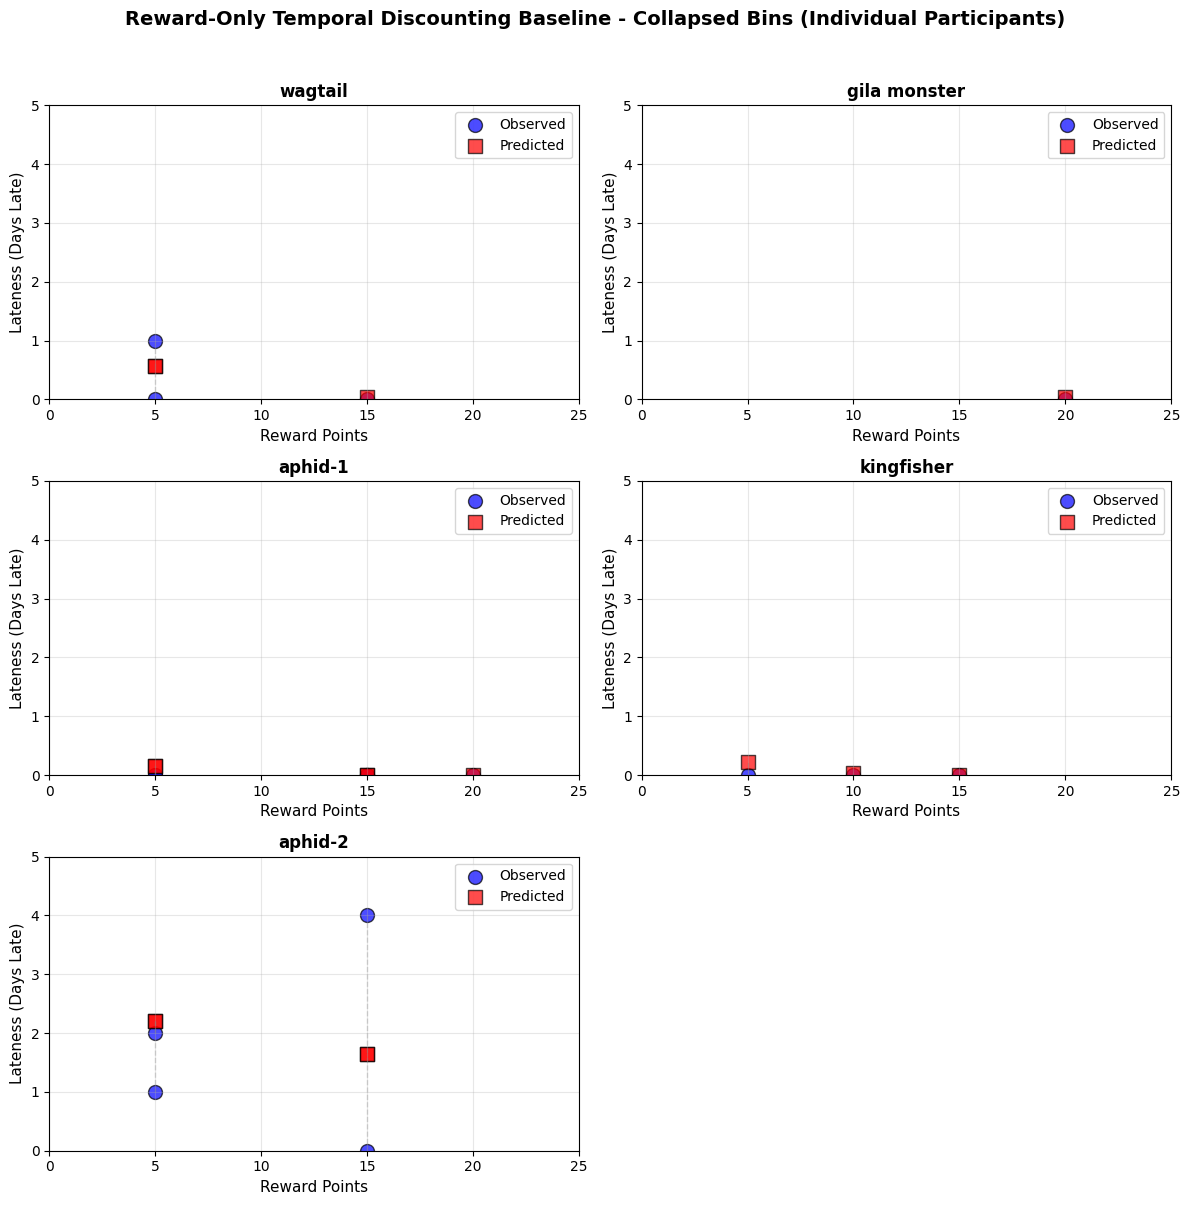

In [27]:
# Visualization - Separate plots for each participant
# x-axis: reward_points
# y-axis: lateness (0-5)
# Each participant gets their own subplot

participants = df_individual['participant_id'].unique()
n_participants = len(participants)

# Create subplots - arrange in a grid
n_cols = 2
n_rows = (n_participants + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
if n_participants == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each participant's data in their own subplot
for i, participant_id in enumerate(participants):
    ax = axes[i]
    participant_data = df_individual[df_individual['participant_id'] == participant_id].sort_values('reward_points')
    
    # Plot observed values
    ax.scatter(
        participant_data['reward_points'],
        participant_data['observed_lateness'],
        label='Observed',
        s=100,
        alpha=0.7,
        color='blue',
        marker='o',
        edgecolors='black',
        linewidths=1
    )
    
    # Plot predicted values
    ax.scatter(
        participant_data['reward_points'],
        participant_data['predicted_lateness'],
        label='Predicted',
        s=100,
        alpha=0.7,
        color='red',
        marker='s',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw lines connecting observed to predicted for same task
    for _, row in participant_data.iterrows():
        ax.plot(
            [row['reward_points'], row['reward_points']],
            [row['observed_lateness'], row['predicted_lateness']],
            color='gray',
            alpha=0.3,
            linestyle='--',
            linewidth=1
        )
    
    ax.set_xlabel('Reward Points', fontsize=11)
    ax.set_ylabel('Lateness (Days Late)', fontsize=11)
    ax.set_title(f'{participant_id}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 5)
    ax.set_yticks(range(0, 6))  # Set y-axis ticks at intervals of 1
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_participants, len(axes)):
    axes[i].axis('off')

plt.suptitle('Reward-Only Temporal Discounting Baseline - Collapsed Bins (Individual Participants)', 
             fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save figure
plot_path = PLOTS_DIR / 'reward_only_memo_baseline_collapsed_individual.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


Figure saved as /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots/reward_only_memo_baseline_collapsed_means.png


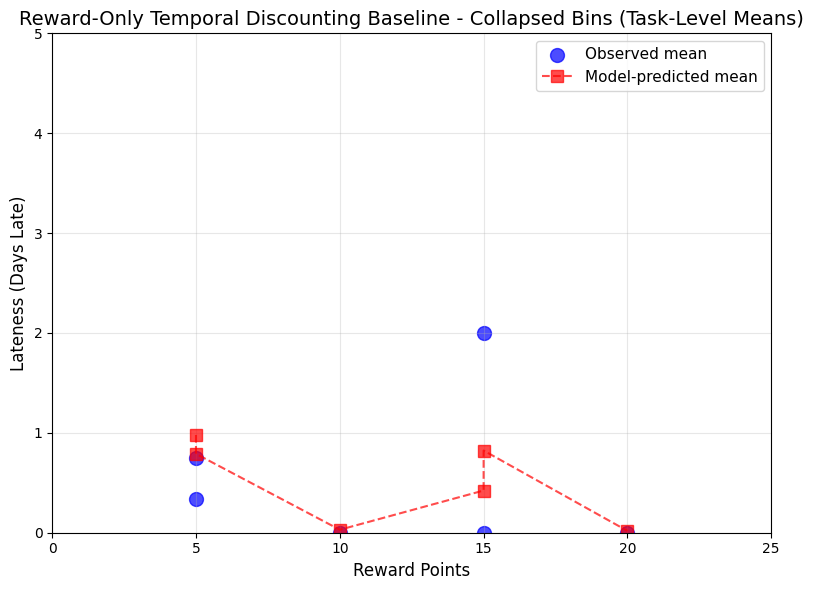

In [28]:
# Visualization - Task-level means
# x-axis: reward_points
# y-axis: lateness (0-5)
# observed means as points
# predicted means as points or a line

plt.figure(figsize=(8, 6))

# Sort by reward_points for better visualization
df_plot = df_predictions.sort_values('reward_points')

# Plot observed means as points
plt.scatter(
    df_plot['reward_points'],
    df_plot['mean_observed'],
    label='Observed mean',
    s=100,
    alpha=0.7,
    color='blue',
    marker='o'
)

# Plot predicted means as a line
plt.plot(
    df_plot['reward_points'],
    df_plot['mean_predicted'],
    label='Model-predicted mean',
    linestyle='--',
    marker='s',
    markersize=8,
    color='red',
    alpha=0.7
)

plt.xlabel('Reward Points', fontsize=12)
plt.ylabel('Lateness (Days Late)', fontsize=12)
plt.title('Reward-Only Temporal Discounting Baseline - Collapsed Bins (Task-Level Means)', fontsize=14)
plt.xlim(0, 25)
plt.ylim(0, 5)
plt.yticks(range(0, 6))  # Set y-axis ticks at intervals of 1
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
plot_path = PLOTS_DIR / 'reward_only_memo_baseline_collapsed_means.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


Figure saved as /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots/reward_only_memo_baseline_collapsed_expected_lateness.png


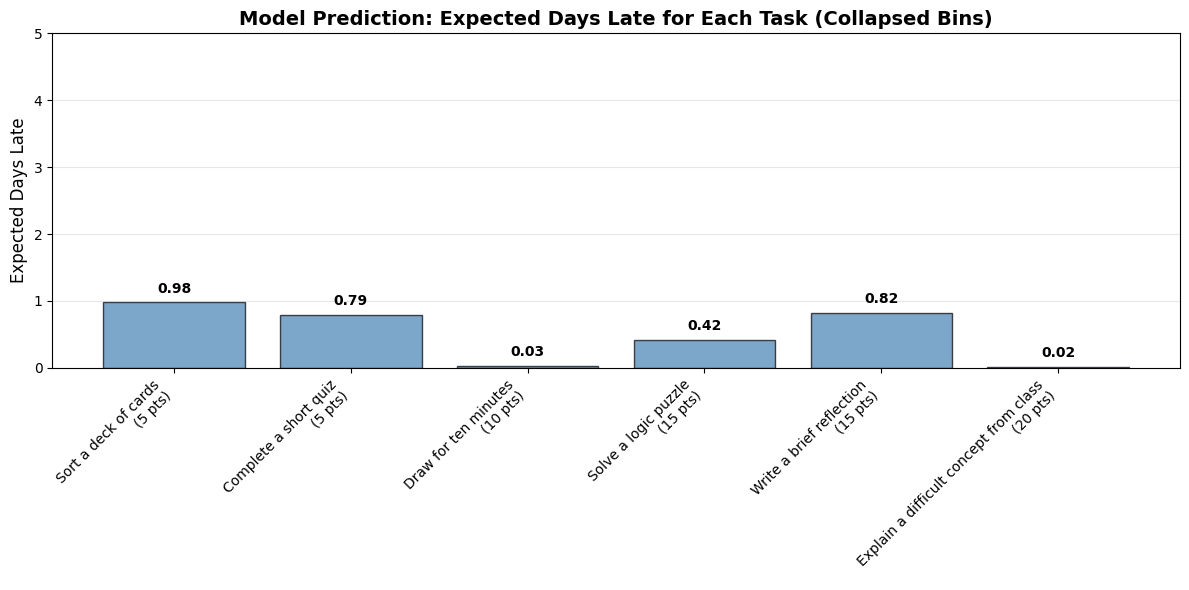

In [29]:
# Plot: Expected days late for each task
# Bar graph where each bar = one task, height = expected days late

# Compute expected days late for each task
task_expected = []
task_names = []
task_rewards = []

for task in df_completed['task'].unique():
    task_df = df_completed[df_completed['task'] == task]
    reward_points = task_df['task_points'].iloc[0]
    
    # Get model predictions averaged across participants
    predicted_expected = []
    for participant_id in task_df['participant_id'].unique():
        beta = beta_estimates[participant_id]
        probs = temporal_discounting_model(beta, float(reward_points))
        expected_lateness = sum(LATENESS_VALUES[i] * float(probs[i]) for i in range(len(LATENESS_VALUES)))
        predicted_expected.append(expected_lateness)
    
    mean_expected = np.mean(predicted_expected) if predicted_expected else 0.0
    
    task_names.append(task)
    task_rewards.append(reward_points)
    task_expected.append(mean_expected)

# Sort by reward points for better visualization
sorted_data = sorted(zip(task_names, task_rewards, task_expected), key=lambda x: x[1])
task_names, task_rewards, task_expected = zip(*sorted_data)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot
bars = ax.bar(range(len(task_names)), task_expected, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)

# Add value labels on top of bars
for i, (name, reward, expected) in enumerate(zip(task_names, task_rewards, task_expected)):
    ax.text(i, expected + 0.1, f'{expected:.2f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal line at y=0
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Customize x-axis
ax.set_xticks(range(len(task_names)))
ax.set_xticklabels([f'{name}\n({reward} pts)' for name, reward in zip(task_names, task_rewards)], 
                   rotation=45, ha='right', fontsize=10)

ax.set_ylabel('Expected Days Late', fontsize=12)
ax.set_title('Model Prediction: Expected Days Late for Each Task (Collapsed Bins)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 5)
ax.set_yticks(range(0, 6))
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# Save figure
plot_path = PLOTS_DIR / 'reward_only_memo_baseline_collapsed_expected_lateness.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()
